In [3]:
# -*- coding: utf-8 -*-
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
 
import datetime  # For datetime objects
import pandas as pd
import backtrader as bt
import numpy as np
# Create a Stratey
class MyStrategy(bt.Strategy):
    params = (
        ('ssa_window', 15),
        ('maperiod', 15),
    )
 
    def log(self, txt, dt=None,isshow=False):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        if isshow:
            print('%s, %s' % (dt.isoformat(), txt))
 
    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
 
        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
 
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
 
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    '买单执行, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))
 
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('买单执行, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))
 
            self.bar_executed = len(self)
 
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('订单取消/Margin/Rejected')
 
        self.order = None
 
    def notify_trade(self, trade):
        if not trade.isclosed:
            return
 
        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
 
    def next(self):
        self.log('Close, %.2f' % self.dataclose[0])
        if self.order:
            return
        if not self.position:
            if self.dataclose[0] > self.sma[0]:
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                self.order = self.buy()
        else:
            if self.dataclose[0] < self.sma[0]:
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
                self.order = self.sell()


In [4]:
cerebro = bt.Cerebro()
cerebro.strats.clear()
cerebro.addstrategy(MyStrategy)
dataframe = pd.read_csv('dfqc.csv', index_col=0, parse_dates=True)
dataframe['openinterest'] = 0
data = bt.feeds.PandasData(dataname=dataframe,
                        fromdate = datetime.datetime(2015, 1, 1),
                        todate = datetime.datetime(2016, 12, 31)
                        )
cerebro.adddata(data)
cerebro.broker.setcash(100.0)
cerebro.addsizer(bt.sizers.FixedSize, stake=10)
cerebro.broker.setcommission(commission=0.0)
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name = 'SharpeRatio')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='DW')
results = cerebro.run()
strat = results[0]
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
print('SR:', strat.analyzers.SharpeRatio.get_analysis())
print('DW:', strat.analyzers.DW.get_analysis())


Starting Portfolio Value: 100.00
Final Portfolio Value: 102.10
SR: OrderedDict([('sharperatio', 0.3559042764961055)])
DW: AutoOrderedDict([('len', 393), ('drawdown', 4.704125443345109), ('moneydown', 5.039999999999949), ('max', AutoOrderedDict([('len', 393), ('drawdown', 6.589509053574725), ('moneydown', 7.05999999999996)]))])


<IPython.core.display.Javascript object>


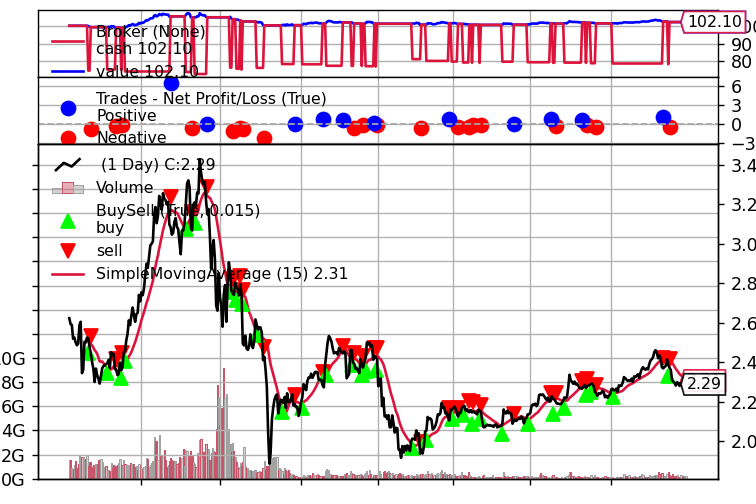

[[<Figure size 432x288 with 4 Axes>]]

In [6]:
cerebro.plot()